In [1]:
# 加载相关工具包
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns

In [2]:
# 创建数据
from sklearn import datasets 
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
data, target = make_blobs(n_samples=10000, centers=2, random_state=1, cluster_std=1.0 )
## 创建训练集和测试集
X_train1,X_test,y_train1,y_test = train_test_split(data, target, test_size=0.2, random_state=1)
## 创建训练集和验证集
X_train,X_val,y_train,y_val = train_test_split(X_train1, y_train1, test_size=0.3, random_state=1)
print("The shape of training X:",X_train.shape)
print("The shape of training y:",y_train.shape)
print("The shape of test X:",X_test.shape)
print("The shape of test y:",y_test.shape)
print("The shape of validation X:",X_val.shape)
print("The shape of validation y:",y_val.shape)

The shape of training X: (5600, 2)
The shape of training y: (5600,)
The shape of test X: (2000, 2)
The shape of test y: (2000,)
The shape of validation X: (2400, 2)
The shape of validation y: (2400,)


In [3]:
#  设置第一层分类器
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

clfs = [SVC(probability = True),RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),KNeighborsClassifier()]

# 设置第二层分类器
from sklearn.linear_model import LinearRegression
lr = LinearRegression()




In [4]:
# 输出第一层的验证集结果与测试集结果
val_features = np.zeros((X_val.shape[0],len(clfs)))  # 初始化验证集结果
test_features = np.zeros((X_test.shape[0],len(clfs)))  # 初始化测试集结果

for i,clf in enumerate(clfs):
    clf.fit(X_train,y_train)
    val_feature = clf.predict_proba(X_val)[:, 1]
    test_feature = clf.predict_proba(X_test)[:,1]
    val_features[:,i] = val_feature
    test_features[:,i] = test_feature
    

In [5]:
# 将第一层的验证集的结果输入第二层训练第二层分类器
lr.fit(val_features,y_val)
# 输出预测的结果
from sklearn.model_selection import cross_val_score
cross_val_score(lr,test_features,y_test,cv=5)

array([1., 1., 1., 1., 1.])

In [8]:
# 1. 简单堆叠3折CV分类
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier

RANDOM_SEED = 42

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()

# Starting from v0.16.0, StackingCVRegressor supports
# `random_state` to get deterministic result.
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],  # 第一层分类器
                            meta_classifier=lr,   # 第二层分类器
                            random_state=RANDOM_SEED)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], ['KNN', 'Random Forest', 'Naive Bayes','StackingClassifier']):
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [Naive Bayes]
Accuracy: 0.93 (+/- 0.02) [StackingClassifier]


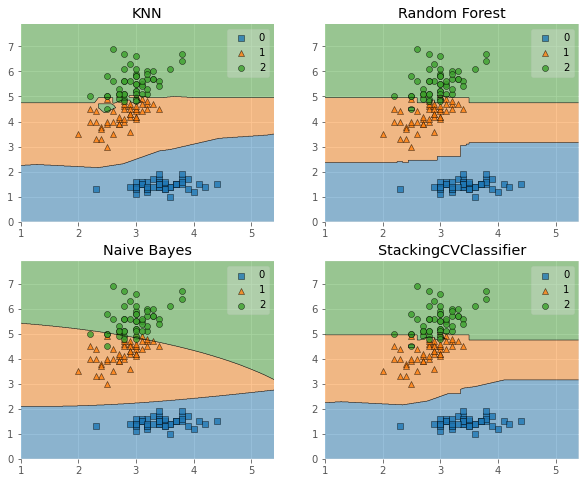

In [9]:
# 我们画出决策边界
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))
for clf, lab, grd in zip([clf1, clf2, clf3, sclf], 
                         ['KNN', 
                          'Random Forest', 
                          'Naive Bayes',
                          'StackingCVClassifier'],
                          itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(lab)
plt.show()



In [10]:
# 2.使用概率作为元特征
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            use_probas=True,  # 
                            meta_classifier=lr,
                            random_state=42)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = cross_val_score(clf, X, y, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [Naive Bayes]
Accuracy: 0.95 (+/- 0.02) [StackingClassifier]


In [11]:
# 如果我们打算多次使用回归算法，我们要做的就是在参数网格中添加一个附加的数字后缀，如下所示：
from sklearn.model_selection import GridSearchCV

# Initializing models

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf1, clf2, clf3], 
                            meta_classifier=lr,
                            random_state=RANDOM_SEED)

params = {'kneighborsclassifier-1__n_neighbors': [1, 5],
          'kneighborsclassifier-2__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta_classifier__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.940 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.940 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.940 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.940 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 50}
0.960 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.953 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestcla

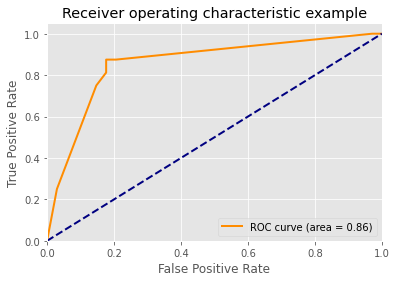

In [12]:
# 5.ROC曲线 decision_function
### 像其他scikit-learn分类器一样，它StackingCVClassifier具有decision_function可用于绘制ROC曲线的方法。
### 请注意，decision_function期望并要求元分类器实现decision_function。
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

iris = datasets.load_iris()
X, y = iris.data[:, [0, 1]], iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=RANDOM_SEED)

clf1 =  LogisticRegression()
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = SVC(random_state=RANDOM_SEED)
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            meta_classifier=lr)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(sclf)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()